In [70]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import random
import numpy as np

# avoid alarms or warning
import warnings
warnings.filterwarnings("ignore")

In [15]:
FILE_PATH = '../datasets/edges/Artist-250.csv'

In [16]:
# # read from csv, ignore headers
G : nx.DiGraph = nx.read_edgelist(FILE_PATH, delimiter=';', create_using=nx.DiGraph(), nodetype=str)  

In [18]:
def generate_rgb(seed: int) -> str:
    # return "#xxxxx"
    random.seed(seed)
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return f"#{r:02x}{g:02x}{b:02x}"

In [80]:
# Take a smaple of the nodes
g: nx.DiGraph = G.subgraph(list(G.nodes)[:1500])

In [133]:
nodes_size = [g.in_degree(node) * 100 for node in g.nodes()]

In [144]:
hubs, _ = nx.hits(g, max_iter=100, tol=1e-08, normalized=True)
# hubs = set(hubs.keys())

# Ordenar los nodos por sus puntajes de hub en orden descendente
sorted_hubs = sorted(hubs.items(), key=lambda item: item[1], reverse=True)

# Definir cuántos hubs principales seleccionar (ejemplo: top 3 hubs)
top_n = 10
top_hubs = sorted_hubs[:top_n]

# Mostrar los principales hubs
print(f"Top {top_n} Hubs:")
for node, score in top_hubs:
    print(f"Nodo {node}: Puntaje de hub {score}")

Top 10 Hubs:
Nodo Maejor_Ali: Puntaje de hub 0.009156850502925518
Nodo Huey: Puntaje de hub 0.00882826126977059
Nodo Drake: Puntaje de hub 0.008794087635002674
Nodo Rocko: Puntaje de hub 0.008710701985621386
Nodo Roscoe_Dash: Puntaje de hub 0.008584832622155281
Nodo Snootie_Wild: Puntaje de hub 0.008241048832301952
Nodo Young_Greatness: Puntaje de hub 0.0077031929648203115
Nodo MiMS: Puntaje de hub 0.0075743262485415816
Nodo J._Dash: Puntaje de hub 0.007416922154679472
Nodo Shop_Boyz: Puntaje de hub 0.0068801999613175655


In [145]:
hubs = [node for node, _ in top_hubs]

In [146]:
nodes_color = [generate_rgb(1) if node in hubs else generate_rgb(10)  for node in g.nodes()]

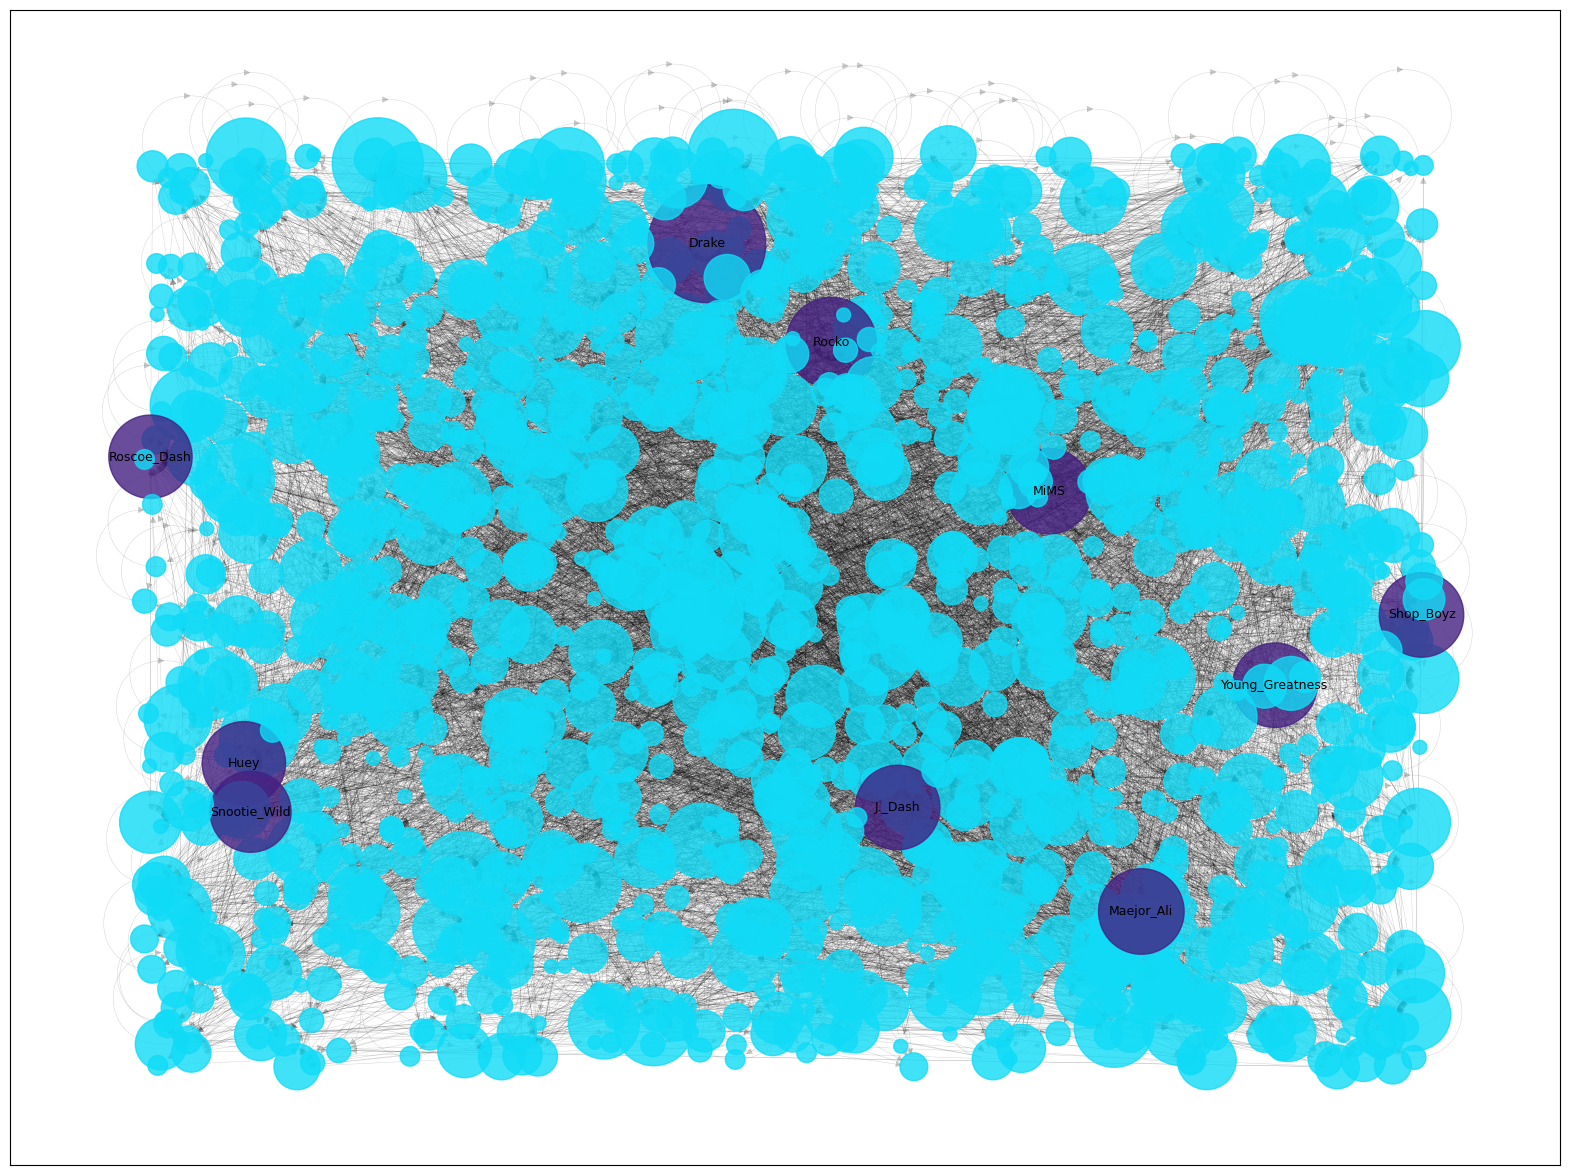

In [151]:
# Aumentar el tamaño de la figura
plt.figure(figsize=(20, 15))

# Establecer la posición de los nodos
pos = nx.random_layout(g)

# Dibujar los nodos
nx.draw_networkx_nodes(g, pos, node_size=nodes_size, node_color=nodes_color, alpha=0.8)

# Dibujar las aristas
nx.draw_networkx_edges(g, pos, width=0.3, alpha=0.2)

# Dibujar etiquetas para los hubs
nx.draw_networkx_labels(
    g, pos, labels={node: node for node in hubs}, font_size=9, font_color="black"
)

# Mostrar la gráfica
plt.show()

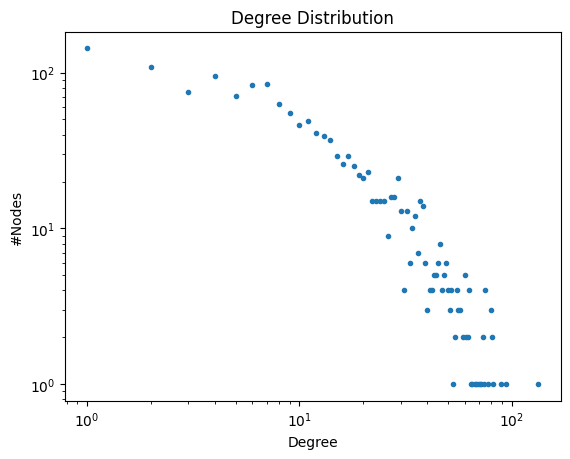

In [148]:
hist = nx.degree_histogram(g)

plt.plot(range(0, len(hist)), hist, ".")
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("#Nodes")
plt.loglog()
plt.show()

Calculating best minimal value for power law fit


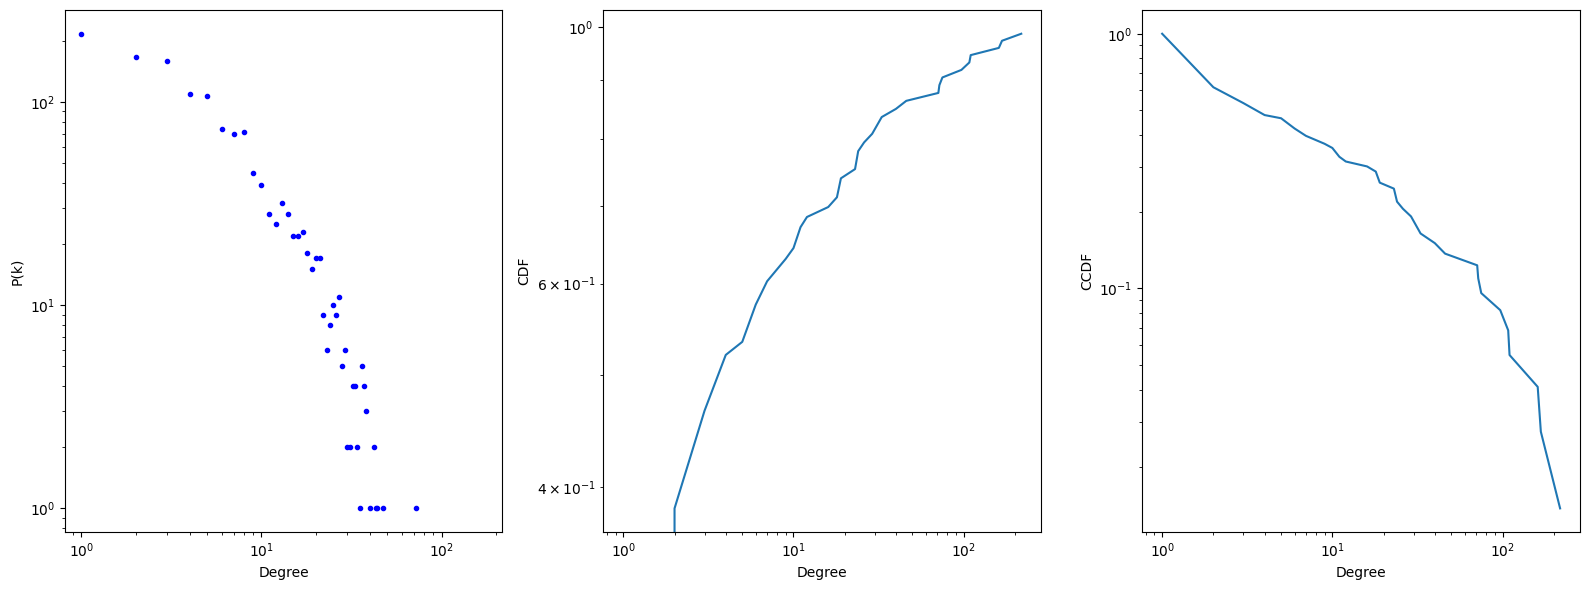

In [89]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import powerlaw

def plot_dist(G):
    M = nx.to_scipy_sparse_array(G)  # Convertimos el grafo a una matriz dispersa de scipy
    xmin = min([d[1] for d in G.degree()])
    indegrees = M.sum(0)  # Suma de los grados de entrada
    degree = np.bincount(indegrees.astype(int))  # Asegúrate de convertir los grados a enteros
    fit = powerlaw.Fit(np.array(degree) + 1, fit_method='KS')

    fig = plt.figure(figsize=(16, 6))

    """ Plot Distribution """
    plt.subplot(1, 3, 1)
    plt.plot(range(len(degree)), degree, 'b.')
    plt.loglog()
    plt.xlim(min(degree), max(degree))
    plt.xlabel('Degree')
    plt.ylabel('P(k)')

    """ Plot CDF """
    plt.subplot(1, 3, 2)
    fit.plot_cdf()
    plt.xlabel('Degree')
    plt.ylabel('CDF')

    """ Plot CCDF """
    plt.subplot(1, 3, 3)
    fit.plot_ccdf()
    plt.xlabel('Degree')
    plt.ylabel('CCDF')

    plt.tight_layout()
    plt.show()

# Ahora puedes llamar a la función con tu grafo g
plot_dist(g)

In [90]:
nx.density(g)

0.004880587058038692

In [91]:
nx.average_clustering(g)

0.045289389880737455